# The comparision between altered and natural dam
In this file. We use all the data of natural and altered peaking to see whether there are obvious differences between hydropeaking and natural dams.

In this programme, the data within the first 3 months are used. Fluctuations between $0.25*standard divation$ are treated as noise and is filtered. We only filter the data for one round in this script.

As is shown below, we can find great differences both in the plots and in statistics. For example, all hydronum of the natual data is less than 100 while the hydronum of altered data is all greater than 100. We can also see from the plot that the altered data fluctuate more frequent than the natural data.

## The main part of programme

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from datetime import datetime

def readtemplate(path):
    filename = path[-4:]
    if filename == '.csv':
        data = pd.read_csv(path, nrows=14000)
    elif filename == 'xlsx':
        data = pd.read_excel(path, nrows=14000)
    return data


def cal_sd(df):
    drop_vec = []
    coverage_time = 4  # refer to 4 time span of the time unit related to the data
    downtemp = 0  # record whether decreasing happened
    uptemp = 0  # record whether increasing happened
    smooth_count = 0
    for i in range(len(df['waterlevel']) - 1):
        currvalue = df.at[i, 'waterlevel']
        gradient = df.at[i + 1, 'waterlevel'] - currvalue
        if gradient > 0:
            if uptemp == 0:
                startpoint = currvalue
                uptemp = 1
            elif smooth_count > coverage_time:
                startpoint = currvalue
                smooth_count = 0
            else:
                smooth_count = 0
        elif gradient == 0 and uptemp == 1:
            smooth_count += 1
        elif gradient < 0 and uptemp == 1:
            top = currvalue
            drop_vec.append(top - startpoint)
            uptemp = 0
            smooth_count = 0
    sd = np.sqrt(np.std(drop_vec))
    return sd


'''
df: 数据集 dataset
x1: 允许一次上升/下降的最长时长，若超过范围则用新的上升覆盖 (tolerance for the max time interval in one single incrasing/decreasing. If the time is beyond the tolerance, we replace the old one with the new one)
x2: 用于筛选固定时间内的上升/下降值，若在时间范围内则保留，反之舍弃(tolerance for the max time interval between one hydropeak.)
x3: 用于筛选固定落差，若小于该落差则被保留，大于该落差舍弃 (tolerance for the max drop between one hydropeak)
x5: 检测的斜率阈值，若出现小于该值的斜率则不检测 (tolerance for the max gradient to be detected)
'''


def filterhydro(df, sd, name):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(df['time'], df['waterlevel'], 'k--', label='Before')
    ax.set_title('Dam %s'%(name))
    global time1, time2, bottom, top, uptemp, downtemp, gradient1, gradient2, timestart, timeend, valuestart, valueend, smooth_count
    # Initialize the data
    cov_time = 4  # refers to 4 interval of time related to the data
    downtemp = 0  # record whether decreasing happened
    uptemp = 0  # record whether increasing happened
    start_val, top, end_val = 0, 0, 0
    time1, time2 = 0, 0
    smooth_count = 0
    lock = 0
    fit_count = 0
    # filterfunction
    for i in range(len(df['waterlevel'])-1):
        currtime = i
        currvalue = df.at[i, 'waterlevel']
        # set the gradient
        gradient = df.at[i+1, 'waterlevel'] - currvalue
        # 遇到大幅度梯度上升，检测附近是否有成对出现的大幅度梯度下降，记录间隔与大小
        # When an increasing gradient is detected, we want to find whether there is decreasing gradient nearby. We record the time interval and waterlevel difference
        if uptemp != 1 or downtemp != 1:
            if gradient > 0:
                if uptemp == 0:
                    time1 = currtime
                    start_val = currvalue
                    uptemp = 1
                elif smooth_count > cov_time:
                    time1 = currtime
                    start_val = currvalue
                    smooth_count = 0
                else:
                    smooth_count = 0
            elif gradient == 0 and uptemp == 1:
                smooth_count += 1
            elif gradient < 0 and uptemp == 1:
                top = currvalue
                time2 = i + 1
                end_val = df.at[i + 1, 'waterlevel']
                downtemp = 1
        # match
        elif downtemp == 1 and uptemp == 1:
            if gradient > 0:
                leftdrop = top - start_val
                rightdrop = top - end_val
                if leftdrop <= sd and rightdrop <= sd:
                    fillnum = (end_val - start_val) / (time2 - time1)
                    for j in range(time1, time2 + 1):
                        df.at[j, 'waterlevel'] = (
                            j - time1) * fillnum + start_val
                    uptemp = 0
                    downtmp = 0
                    lock = 0
                    fit_count += 1
                elif rightdrop >= sd and leftdrop < sd:
                    for j in range(time1, time2 + 1):
                        if df.at[j, 'waterlevel'] >= start_val:
                            df.at[j, 'waterlevel'] = start_val
                        else:
                            break
                    downtemp = 0
                    uptemp = 0
                    lock = 0
                    fit_count += 1
                elif leftdrop >= sd and rightdrop < sd:
                    for j in range(time2, time1 - 1, -1):
                        if df.at[j, 'waterlevel'] >= end_val:
                            df.at[j, 'waterlevel'] = end_val
                        else:
                            break

                    downtemp = 0
                    fit_count += 1
                    time1 = currtime
                    start_val = currvalue
                    uptemp = 1
                lock = 0
                smooth_count = 0
                time1 = currtime
                start_val = currvalue
                uptemp = 1
                downtemp = 0
            elif gradient == 0:
                smooth_count += 1  # record the times of no change
            elif gradient < 0:
                if smooth_count > cov_time:
                    lock = 1  # lock the record of time and value if there are more than 4 times with no change
                if lock != 1:
                    time2 = currtime + 1
                    end_val = df.at[i + 1, 'waterlevel']
                    smooth_count = 0
    print('We have filtered', fit_count, 'flowing within the sd')
 #   ax.set_title('The waterlevel before and after filtering')
 #   ax.set_xlabel('time')
  #  ax.set_ylabel('water level')
 #   ax.plot(df['time'], df['waterlevel'], label='After')
 #   ax.legend(loc='best')
 #   plt.show()
#    return df


def filterhydro_plot(df, sd, name):
    #ctn = 0
    #while True:
    filterhydro(df, sd, name)
    #    ctn = input('Does the filter look plausible? If yes, input 1:\n')
       #if ctn == '1':
           # break

def datetime_preprocess(df):
    df['time'] = pd.to_datetime(df['time'])
    df1 = df.set_index('time')
    df1['num'] = 1
    day = df1.to_period('D')
    date_num = df1.resample('D').sum()
    date_list = list(x.strftime('%d-%m-%Y') for x in date_num.index)
    date_num = list(date_num['num'])
    return date_num, date_list
            
def searchhydro(df, sd):
    global time1, time2, bottom, top, uptemp, downtemp, timestart, timeend, valuestart, valueend, smooth_count
    # Initialize the data
    cov_time = 4  # refers to 4 interval of time related to the data
    hydropeak_num = 0
    downtemp = 0  # record whether decreasing happened
    uptemp = 0  # record whether increasing happened
    bottom, top = 0, 0
    time1, time2 = 0, 0
    timestart = []
    timeend = []
    valuestart = []
    valueend = []
    smooth_count = 0
    rightdrop = []
    leftdrop = []
    rightslope = []
    leftslope = []
    peak_duration = []
    peak_duration_count = 0
    smooth_count = 0
    
    #import the time series
    date_num, date_list = datetime_preprocess(df)
    last_hydronum = 0
    last_day = 0
    day_count = 0 
    hydronum_daily = {'number':[],'date':[]}
    for i in range(len(df['waterlevel'])-1):
        #append the hydronum
        if i-last_day == date_num[day_count]-1:
            hydronum_daily['number'].append(hydropeak_num-last_hydronum)
            hydronum_daily['date'].append(date_list[day_count])
            last_hydronum = hydropeak_num
            last_day = i
            if day_count < len(date_list)-1:
                day_count += 1
        elif i == len(df['waterlevel'])-1:
            hydronum_daily['number'].append(hydropeak_num-last_hydronum)
            hydronum_daily['date'].append(date_list[day_count])
            last_hydronum = hydropeak_num
        #start searching hydronum
        currtime = i
        currvalue = df.at[i, 'waterlevel']
        # set the gradient
        gradient = df.at[i+1, 'waterlevel'] - currvalue
        # 遇到大幅度梯度上升，检测附近是否有成对出现的大幅度梯度下降，记录间隔与大小
        # When an increasing gradient is detected, we want to find whether there is decreasing gradient nearby. We record the time interval and waterlevel difference
        if uptemp != 1 or downtemp != 1:
            if gradient > 0:
                if uptemp == 0:
                    time1 = currtime
                    start_val = currvalue
                    uptemp = 1
                    peak_duration_count = 0
                elif smooth_count > cov_time and uptemp == 1:
                    time1 = currtime
                    start_val = currvalue
                    smooth_count = 0
                    peak_duration_count = 0
                else:
                    smooth_count = 0
                    peak_duration_count = 0
            elif gradient == 0 and uptemp == 1:
                smooth_count += 1
                peak_duration_count += 1
            elif gradient < 0 and uptemp == 1:
                top = currvalue
                toptime = i
                time2 = currtime + 1
                end_val = df.at[i + 1, 'waterlevel']
                downtemp = 1
                smooth_count = 0
                peak_duration_count = 0
            # match
            
        elif downtemp == 1 and uptemp == 1:
            if gradient > 0:
                hydropeak_num += 1
                start_time = df.at[time1, 'time']
                end_time = df.at[time2, 'time']
                top_time = df.at[toptime, 'time']
                timestart.append(start_time)
                timeend.append(end_time)
                valuestart.append(start_val)
                valueend.append(end_val)
                rttime = to_integer(top_time - start_time)
                lttime = to_integer(end_time - top_time)
                rightdrop.append(top - start_val)
                leftdrop.append(top - end_val)
                rightslope.append((top - end_val)/rttime)
                leftslope.append((top - end_val)/lttime)
                peak_duration.append(peak_duration_count)
                downtemp = 0
                time1 = currtime
                start_val = currvalue
                smooth_count = 0
            elif gradient == 0:
                smooth_count += 1
            elif gradient < 0:
                if smooth_count > cov_time:
                    hydropeak_num += 1
                    start_time = df.at[time1, 'time']
                    end_time = df.at[time2, 'time']
                    top_time = df.at[toptime, 'time']
                    timestart.append(start_time)
                    timeend.append(end_time)
                    valuestart.append(start_val)
                    valueend.append(end_val)
                    rttime = to_integer(top_time - start_time)
                    lttime = to_integer(end_time - top_time)
                    rightdrop.append(top - start_val)
                    leftdrop.append(top - end_val)
                    rightslope.append((top - end_val)/rttime)
                    leftslope.append((top - end_val)/lttime)
                    peak_duration.append(peak_duration_count)
                    uptemp = 0
                    downtemp = 0
                else:
                    end_val = df.at[i + 1, 'waterlevel']
                    time2 = currtime + 1
                    smooth_count = 0
    #data_tocsv(leftdrop,rightdrop,timestart,timeend,rightslope,leftslope,peak_duration_count)    
    #daily_hydronum_tocsv(hydronum_daily)
    print('The number of hydropeak is', hydropeak_num)
    print('The sd is', sd)
    return np.var(rightdrop), np.var(leftdrop), np.mean(peak_duration), hydropeak_num
    #plothydro()   

def to_integer(datetime):
    return int(datetime.total_seconds()/60)

def daily_hydronum_tocsv(hydronum_daily):
    hydronum_daily = pd.DataFrame(hydronum_daily)
    hydronum_daily.to_csv('Daily_hydronum.csv')
    
def data_tocsv(leftdrop,rightdrop,timestart,timeend,rightslope,leftslope,peak_duration_count):
    AllData = {
        'leftdrop': leftdrop,
        'rightdrop': rightdrop,
        'starting_time':timestart,
        'ending_time':timeend,
        'rightslope':rightslope,
        'leftslope':leftslope,
        'peak_duration':peak_duration_count
    }
    AllData = pd.DataFrame(AllData,columns=['leftdrop',
                                              'rightdrop',
                                              'starting_time',
                                             'ending_time',
                                             'rightslope',
                                             'leftslope',
                                              'peak_duration'
                                             ])
    AllData.to_csv('Output.csv')

def plothydro():
    plt.title('list')
    plt.xlabel('time')
    plt.ylabel('water level')
    plt.plot(df['time'], df['waterlevel'])
    plt.scatter(timestart, valuestart, c='g')
    plt.scatter(timeend, valueend, c='r')
    plt.show()    

def main_altered():
    print('start')
    path = '../dataset/Waterlevel_Altered.xlsx'
    #path = input('Please input the data path\n')
    # 确认输入文件类型符合且文件存在
    filename = path[-4:]
    if filename != '.csv' and filename != 'xlsx':
        path = input('please input a excel or csv file\n')
    else:
        df = readtemplate(path)
    rightslope = []
    leftslope = []
    hydronum = []
    peakduration = []
    stat_list = [2009,2011,2019,2056,2084,2085,2372,2473]
    for j in stat_list:
        print('\nFor dam:%s'%(j))
        df.rename(columns = {j:'waterlevel'},inplace=True)
        sd = 0.25 * cal_sd(df)
        filterhydro_plot(df, sd, j)
        rt_slope, lt_slope, pk_duration, hydropeak_num = searchhydro(df, sd)
        rightslope.append(rt_slope)
        leftslope.append(lt_slope)
        hydronum.append(hydropeak_num)
        df.rename(columns = {'waterlevel':j},inplace=True)
    data = {'station':stat_list,'rightslope':rightslope,'leftslope':leftslope,'hydronum':hydronum}
    frame = pd.DataFrame(data)
    print(frame)
    print('finished')

def main_natural():
    print('start')
    path = '../dataset/Waterlevel_Natural1.xlsx'
    #path = input('Please input the data path\n')
    # 确认输入文件类型符合且文件存在
    filename = path[-4:]
    if filename != '.csv' and filename != 'xlsx':
        path = input('please input a excel or csv file\n')
    else:
        df = readtemplate(path)
    rightslope = []
    leftslope = []
    hydronum = []
    peakduration = []
    stat_list = [2425,2016,2029,2030,2044,2070,2091,2135,2143,2152,2415,2457,2462]    
    for j in stat_list:
        print('\nFor dam:%s'%(j))
        df.rename(columns = {j:'waterlevel'},inplace=True)
        sd = 0.25 * cal_sd(df)
        filterhydro_plot(df, sd, j)
        rt_slope, lt_slope, pk_duration, hydropeak_num = searchhydro(df, sd)
        rightslope.append(rt_slope)
        leftslope.append(lt_slope)
        hydronum.append(hydropeak_num)
        df.rename(columns = {'waterlevel':j},inplace=True)
    data = {'station':stat_list,'rightslope':rightslope,'leftslope':leftslope,'hydronum':hydronum}
    frame = pd.DataFrame(data)
    print(frame)
    print('finished')


## 1. The statistics for the natural peaking dam

start

For dam:2425
We have filtered 56 flowing within the sd
The number of hydropeak is 71
The sd is 0.25509751327894303

For dam:2016
We have filtered 67 flowing within the sd
The number of hydropeak is 60
The sd is 0.1485937656771891

For dam:2029
We have filtered 85 flowing within the sd
The number of hydropeak is 89
The sd is 0.12795856952330964

For dam:2030
We have filtered 42 flowing within the sd
The number of hydropeak is 91
The sd is 0.13481171845267037

For dam:2044
We have filtered 29 flowing within the sd
The number of hydropeak is 45
The sd is 0.23259231233746072

For dam:2070
We have filtered 32 flowing within the sd
The number of hydropeak is 92
The sd is 0.2686292457716498

For dam:2091
We have filtered 67 flowing within the sd
The number of hydropeak is 73
The sd is 0.10531988175840376

For dam:2135
We have filtered 10 flowing within the sd
The number of hydropeak is 97
The sd is 0.20292652238036987

For dam:2143
We have filtered 32 flowing within the sd
The number o

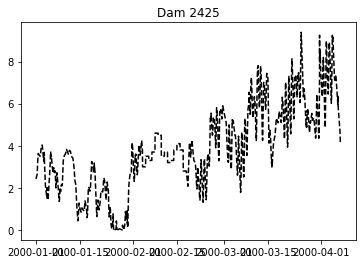

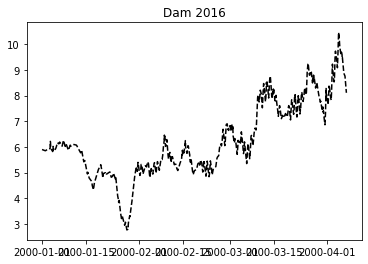

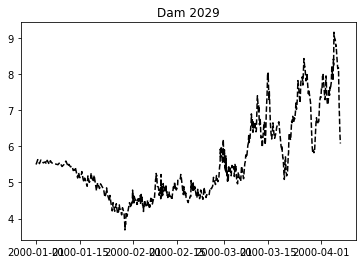

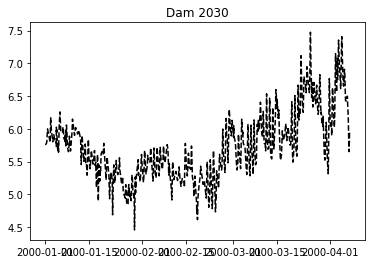

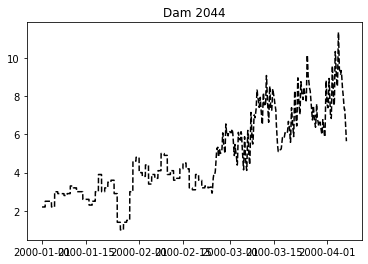

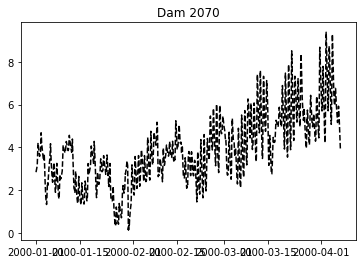

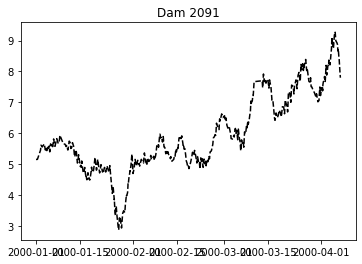

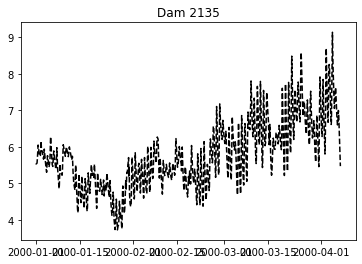

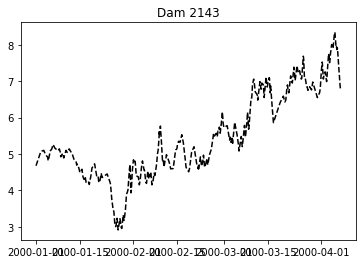

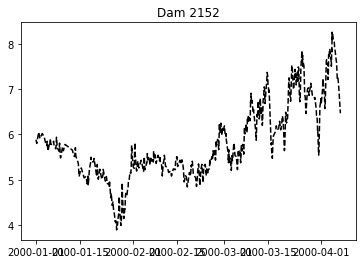

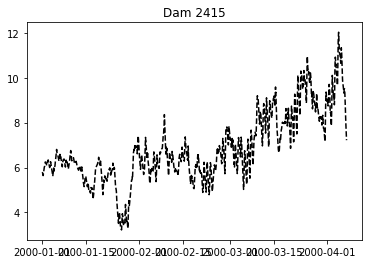

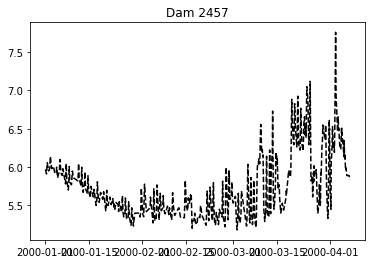

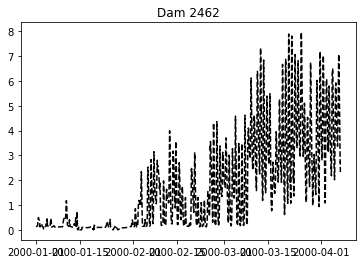

In [68]:
if __name__ == "__main__":
    main_natural()

## 2. The statistics for the altered peaking dam

start

For dam:2009
We have filtered 148 flowing within the sd
The number of hydropeak is 113
The sd is 0.16639033870597658

For dam:2011
We have filtered 207 flowing within the sd
The number of hydropeak is 139
The sd is 0.22032377624586866

For dam:2019
We have filtered 559 flowing within the sd
The number of hydropeak is 437
The sd is 0.16643309775453985

For dam:2056
We have filtered 145 flowing within the sd
The number of hydropeak is 102
The sd is 0.25370810714204267

For dam:2084
We have filtered 210 flowing within the sd
The number of hydropeak is 153
The sd is 0.19225931136476332

For dam:2085
We have filtered 88 flowing within the sd
The number of hydropeak is 154
The sd is 0.1903952187873183

For dam:2372
We have filtered 175 flowing within the sd
The number of hydropeak is 120
The sd is 0.19378616350363556

For dam:2473
We have filtered 125 flowing within the sd
The number of hydropeak is 103
The sd is 0.19917782670608553
   station  rightslope  leftslope  hydronum
0     20

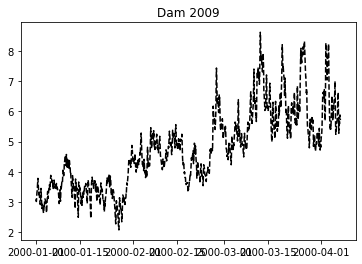

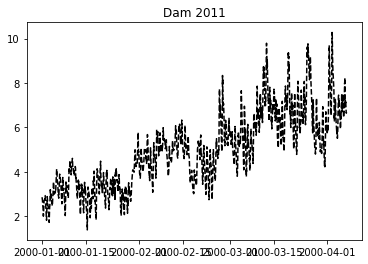

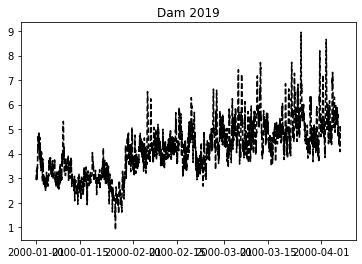

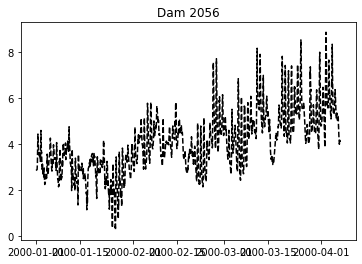

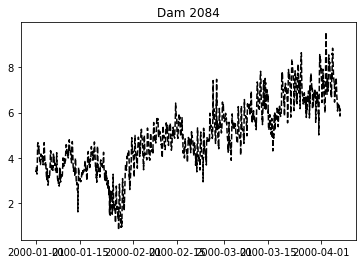

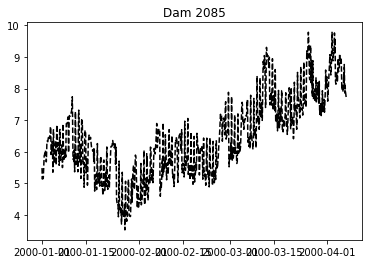

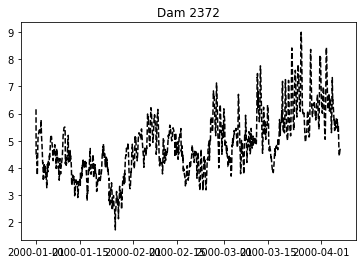

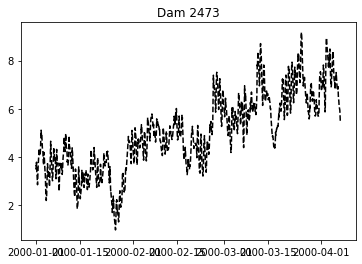

In [69]:
if __name__ == "__main__":
    main_altered()